In [1]:
import os, sys
HOME_DIR = os.path.join(os.getcwd(), '..')
sys.path.append(HOME_DIR)
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit import Chem
import torch
from torch_geometric.loader import DataLoader
from substrate_metric_learning.networks import Net
from substrate_metric_learning.utils import *
from substrate_metric_learning.features import smiles_to_graph_substrate, smiles_to_graph
from rdkit.Chem import Draw
from tqdm.notebook import tqdm
import random

from sklearn.decomposition import PCA
from sklearn import manifold
from umap import UMAP
import sklearn


import matplotlib

def save_fig(ax,file_path):
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt = ax.get_figure()
    plt.savefig(file_path, transparent=True)
    return

/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/dist

In [2]:
config_path = os.path.join(HOME_DIR, "configs/hparams_default.yaml")
config = Objdict(yaml.safe_load(open(config_path)))
input_dim = 133
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1.172
model_pretrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_pretrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_56_sum_r2_1.538.pth"))
model_untrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_untrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_0.pth"))

@torch.no_grad()
def get_embedding_from_smi(smi_list, c_index_list, model, device):
    assert len(smi_list) == len(c_index_list)
    assert model.pool_method == 'c'
    train_dataset = [smiles_to_graph_substrate(smiles=smi_list[i], s=0, y=0, atm_idx=[c_index_list[i]]) for i in range(len(smi_list))]
    loader = DataLoader(train_dataset, 128, shuffle=False)
    model.eval()
    embeddings = []
    for data in loader:
        data = data.to(device)
        _, emb = model(data.x, data.edge_index, data.batch, data.atm_idx)
        embeddings.append(emb.cpu().detach().numpy())
    return np.concatenate(embeddings, axis=0)

In [3]:
df_temp = pd.read_csv('temp_buyable.csv')
df_temp

,smiles,cluster,dim1,dim2
0,BrC1=CC=C(C=O)C=C1,6,17.931244,-16.849379
1,BrC1=CC=CC=C1,8,11.323627,-11.400373
2,CC(=O)C1=CC=C(Br)C=C1,6,14.835684,-18.505522
3,COC1=CC=C(Br)C=C1,8,7.367188,-13.063218
4,CC1=CC=C(Br)C=C1,8,8.093181,-13.837367
...,...,...,...,...
2676,COC1=CC(Br)=C(C=C1)N1CCCCC1,4,3.419410,10.136529
2677,BrC1=CC=C(C#N)C(=C1)N1CCOCC1,9,-10.818709,1.661949
2678,FS(F)(F)(F)(F)C1=CC(Br)=CC(C=O)=C1,2,-11.433393,-6.197806
2679,CC1=CC(Br)=CC(=C1)C(F)F,0,0.276542,-15.222402


In [4]:
data_buyable = pd.read_csv("../data/buyable_aryl_bromides.csv")
data_buyable = data_buyable[data_buyable['informer'] == False]
data_buyable

,smiles,c_index,x_index,in_doyle,informer
0,BrC1=CC=C(C=O)C=C1,1,0,False,False
1,BrC1=CC=CC=C1,1,0,False,False
2,CC(=O)C1=CC=C(Br)C=C1,6,7,False,False
3,COC1=CC=C(Br)C=C1,5,6,False,False
4,CC1=CC=C(Br)C=C1,4,5,False,False
...,...,...,...,...,...
2676,COC1=CC(Br)=C(C=C1)N1CCCCC1,4,5,False,False
2677,BrC1=CC=C(C#N)C(=C1)N1CCOCC1,1,0,False,False
2678,FS(F)(F)(F)(F)C1=CC(Br)=CC(C=O)=C1,8,9,False,False
2679,CC1=CC(Br)=CC(=C1)C(F)F,3,4,False,False


In [5]:
data_buyable['cluster'] = df_temp['cluster']
data_buyable

,smiles,c_index,x_index,in_doyle,informer,cluster
0,BrC1=CC=C(C=O)C=C1,1,0,False,False,6
1,BrC1=CC=CC=C1,1,0,False,False,8
2,CC(=O)C1=CC=C(Br)C=C1,6,7,False,False,6
3,COC1=CC=C(Br)C=C1,5,6,False,False,8
4,CC1=CC=C(Br)C=C1,4,5,False,False,8
...,...,...,...,...,...,...
2676,COC1=CC(Br)=C(C=C1)N1CCCCC1,4,5,False,False,4
2677,BrC1=CC=C(C#N)C(=C1)N1CCOCC1,1,0,False,False,9
2678,FS(F)(F)(F)(F)C1=CC(Br)=CC(C=O)=C1,8,9,False,False,2
2679,CC1=CC(Br)=CC(=C1)C(F)F,3,4,False,False,0


In [6]:
smiles_picked = [
    "C1=CC(C(=O)OC(C)(C)C)=CC(Br)=C1",
    "C1=CC=C(Br)C2=CC(C)=CC=C12",
    "C1=CC(CCC(=O)OCC)=CC=C1Br",
    "C(Br)1=C(CF)C=CC=C1",
    "C1=CC(F)=CC(Br)=C1F",
    "C1=C(Cl)C(OCC)=C(Cl)C=C1Br",
    "C1=CC(C(=O)C#N)=CC=C1Br",
    "C(Br)1=CC(C(C)(C)C)=CC=C1OCC1=CC=CC=C1",
    "C(Br)1=CC(OC(F)(F)F)=C(OC)C=C1",
    "C(Br)1=CC=CC(C2=NC=CC=N2)=C1",
    "C1=CC=C(Br)C(N(C(=O)OC(C)(C)C)C)=C1",
    "C1(C=CC(C(C)=O)=CC=1C(F)(F)F)Br",
    "C1=C(Br)C(C)=CC(OC)=C1C",
    "C(Br)1=CC=C(Cl)C(C)=C1F",
    "C(Br)1=CC=C(C(=O)OCC2=CC=CC=C2)C(F)=C1"
]

smiles_picked_can = [Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True) for s in smiles_picked]

in_picked = []
for smi in data_buyable.smiles:
    smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi), canonical=True)
    if smi in smiles_picked_can:
        in_picked.append(True)
    else:
        in_picked.append(False)

data_buyable['picked'] = in_picked

In [7]:
data_buyable

,smiles,c_index,x_index,in_doyle,informer,cluster,picked
0,BrC1=CC=C(C=O)C=C1,1,0,False,False,6,False
1,BrC1=CC=CC=C1,1,0,False,False,8,False
2,CC(=O)C1=CC=C(Br)C=C1,6,7,False,False,6,False
3,COC1=CC=C(Br)C=C1,5,6,False,False,8,False
4,CC1=CC=C(Br)C=C1,4,5,False,False,8,False
...,...,...,...,...,...,...,...
2676,COC1=CC(Br)=C(C=C1)N1CCCCC1,4,5,False,False,4,False
2677,BrC1=CC=C(C#N)C(=C1)N1CCOCC1,1,0,False,False,9,False
2678,FS(F)(F)(F)(F)C1=CC(Br)=CC(C=O)=C1,8,9,False,False,2,False
2679,CC1=CC(Br)=CC(=C1)C(F)F,3,4,False,False,0,False


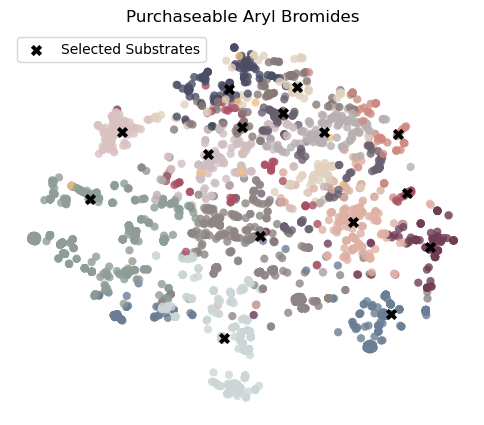

In [30]:
fig, ax = plt.subplots(figsize=(6, 5))

c_list_temp = data_buyable.cluster.to_list()
title = 'Purchaseable Aryl Bromides'

hex_colors = [
    '703D57', 'e2cbc8', 'cad8d8', 'e5d1b7', 'a6a2ae', 
    'e5cdcc', '184971', 'b3756e', '64979d', 'cea68f', 
    'd15362', '3e4461', '7a7071', 'ddb0a8', 'f4bf7f'
]


# Convert hex color values to RGB values
rgb_colors = [tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4)) for hex_color in hex_colors]

# Normalize the RGB values to the range 0-1 (required by matplotlib)
rgb_normalized = [(r/255, g/255, b/255) for r, g, b in rgb_colors]

# Now we'll create a colormap from the list of normalized RGB values.
from matplotlib.colors import LinearSegmentedColormap

custom_colormap = LinearSegmentedColormap.from_list('custom_cmap', rgb_normalized)


sns.scatterplot(x='dim1', y='dim2', data=df_temp, s=35, alpha=0.8, linewidth=0, c=c_list_temp, cmap=custom_colormap, edgecolor=None, ax=ax).set_title(title)
ax.scatter(x=df_temp['dim1'][data_buyable['picked'] == True], y=df_temp['dim2'][data_buyable['picked'] == True], s=65, alpha=1.0, linewidth=0, marker='X', c='black', edgecolor=None, label='Selected Substrates')

# Remove axes
plt.axis('off')
plt.gca().set_facecolor('none')
plt.legend(loc="upper left")
# plt.show()
save_fig(ax, 'tsne_buyable_ArBr_picked.pdf')
# plt.savefig('tsne_buyable_ArBr_picked.png', dpi=300, bbox_inches='tight', transparent=True)